In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from S00_utils import plot_res, store_results



In [2]:
df = pd.read_excel("output/S21__2025-04-21-052727.xlsx")
df = df.set_index("Unnamed: 0")
df.index.names = ["id"]
df.head()

,m1,m2,m3,s1__autocorrelation__lag_8,s1__autocorrelation__lag_9,s1__autocorrelation__lag_7,s1__autocorrelation__lag_6,s1__autocorrelation__lag_5,s1__autocorrelation__lag_4,s1__longest_strike_above_mean,...,s1__ar_coefficient__coeff_3__k_10,s1__approximate_entropy__m_2__r_0.1,s1__lempel_ziv_complexity__bins_3,s1__partial_autocorrelation__lag_4,"s1__fft_coefficient__attr_""abs""__coeff_7","s1__agg_autocorrelation__f_agg_""var""__maxlag_40",s1__spkt_welch_density__coeff_2,y1,y2,y3
id,,,,,,,,,,,,,,,,,,,,,
E001,150.223716,1176.177278,1.142097,-0.305434,-0.519191,-0.074829,0.159896,0.385790,0.590387,14,...,0.183996,0.158567,0.204152,-0.360084,0.293617,0.499488,5.886812e-08,55.460434,1.065917,114.578620
E002,102.534268,1483.654982,1.104716,-0.243785,-0.454262,-0.021002,0.202836,0.416423,0.608972,14,...,0.184370,0.144742,0.203008,-0.344364,6.142373,0.477743,3.643621e-06,50.640306,1.285666,124.651484
E003,119.890549,1254.897451,2.162773,-0.329006,-0.543405,-0.095913,0.142612,0.373002,0.582151,14,...,0.184036,0.144268,0.208163,-0.364611,26.783283,0.506435,1.590028e-04,50.832405,1.154859,57.018054
E004,162.830799,1302.043195,1.308283,-0.065152,-0.266498,0.138913,0.337187,0.521401,0.683873,16,...,0.187213,0.137326,0.193662,-0.355441,33.227591,0.460547,7.926165e-04,62.476545,1.025161,132.221218
E005,165.720956,1154.482314,1.566830,-0.304881,-0.518177,-0.074836,0.159321,0.384728,0.589003,14,...,0.183978,0.128546,0.192440,-0.357588,11.439470,0.497940,1.462831e-04,57.634438,1.043776,92.160269


In [3]:
colsY = ["y1", "y2", "y3"]
colsX = [c for c in df.columns if c not in colsY]

X = df[colsX]
Y = df[colsY]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print(X_train.shape)
print(Y_train.shape)


(70, 47)
(70, 3)


In [4]:
scX = MinMaxScaler()
X_train_std = scX.fit_transform(X_train)
X_test_std = scX.transform(X_test)

scY = MinMaxScaler()
Y_train_std = scY.fit_transform(Y_train)
Y_test_std = scY.transform(Y_test)

In [5]:
# Convert to 2D PyTorch tensors
X_train_std = torch.tensor(X_train_std, dtype=torch.float32)
Y_train_std = torch.tensor(Y_train_std, dtype=torch.float32)
X_test_std = torch.tensor(X_test_std, dtype=torch.float32)
Y_test_std = torch.tensor(Y_test_std, dtype=torch.float32)

In [6]:
class MyModel(nn.Module):
    def __init__(
        self,
        num_tabular_features,
        output_size,
        embedding_size,
    ):
        super().__init__()

        self.num_tabular_features = num_tabular_features

        # Embeddeding layer
        self.embedding_size = embedding_size
        self.embedders_tab_vars = nn.ModuleList(
            [
                nn.Linear(1, self.embedding_size)
                for _ in range(self.num_tabular_features)
            ]
        )

        self.vsn_tab_vars = VariableSelectionNetwork(
            num_inputs=num_tabular_features,
            input_dim=self.embedding_size,
            hidden_dim=num_tabular_features,  # This is the output size
        )

        # MLP for tabular data
        self.mlp = nn.Sequential(
            nn.Linear(num_tabular_features, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU()
        )

        self.regressor = nn.Sequential(
            nn.Linear(32, 64), nn.ReLU(), nn.Linear(64, output_size)
        )

    def forward(self, x_tab):
        # x_tab: (batch, num_tabular_features)

        tab_out = torch.stack(
            [
                self.embedders_tab_vars[i](x_tab[Ellipsis, i].unsqueeze(-1))
                for i in range(0, self.num_tabular_features)
            ],
            axis=-2,
        )  # (batch, num_features, embedding_size)

        tab_out, vsn_weights = self.vsn_tab_vars(tab_out)
        tab_out = self.mlp(tab_out)
        output = self.regressor(tab_out)
        return output.squeeze(-1), vsn_weights


class GatedResidualNetwork(nn.Module):
    def __init__(
        self, input_dim, hidden_dim, output_dim, context_dim=None, dropout=0.1
    ):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.context_linear = (
            nn.Linear(context_dim, hidden_dim) if context_dim is not None else None
        )
        self.elu = nn.ELU()
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.gate = nn.Linear(output_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.skip = (
            nn.Linear(input_dim, output_dim) if input_dim != output_dim else None
        )
        self.layer_norm = nn.LayerNorm(output_dim)

    def forward(self, x, context=None):
        out = self.linear1(x)
        if context is not None:
            out += self.context_linear(context)
        out = self.elu(out)
        out = self.linear2(out)
        out = self.dropout(out)
        gated = self.sigmoid(self.gate(out))
        out = out * gated
        skip = self.skip(x) if self.skip is not None else x
        out = self.layer_norm(out + skip)
        return out


class VariableSelectionNetwork(nn.Module):
    def __init__(
        self, num_inputs, input_dim, hidden_dim, context_dim=None, dropout=0.1
    ):
        super().__init__()
        self.num_inputs = num_inputs
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.variable_grns = nn.ModuleList(
            [
                GatedResidualNetwork(
                    input_dim, hidden_dim, hidden_dim, context_dim, dropout
                )
                for _ in range(num_inputs)
            ]
        )
        self.softmax = nn.Softmax(dim=-1)
        self.weight_grn = GatedResidualNetwork(
            num_inputs * hidden_dim, hidden_dim, num_inputs, context_dim, dropout
        )

    def forward(self, x, context=None):
        # x: (batch, num_inputs, input_dim)
        var_outputs = []
        for i, grn in enumerate(self.variable_grns):
            var_out = grn(x[:, i, :], context)
            var_outputs.append(var_out)
        var_outputs = torch.stack(var_outputs, dim=1)  # (batch, num_inputs, hidden_dim)
        flattened = var_outputs.view(var_outputs.size(0), -1)
        weights = self.weight_grn(flattened, context)
        weights = self.softmax(weights)  # (batch, num_inputs)
        # Weighted sum of variable outputs
        weighted_output = (var_outputs * weights.unsqueeze(-1)).sum(dim=1)
        return weighted_output, weights  # (batch, hidden_dim), (batch, num_inputs)


In [7]:
num_tabular_features = X_train.shape[1]
output_size = Y_train.shape[1]
embedding_size = 8

# Define the model
model = MyModel(num_tabular_features=num_tabular_features, output_size=3, embedding_size=embedding_size)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

MSE: 0.00
RMSE: 0.04


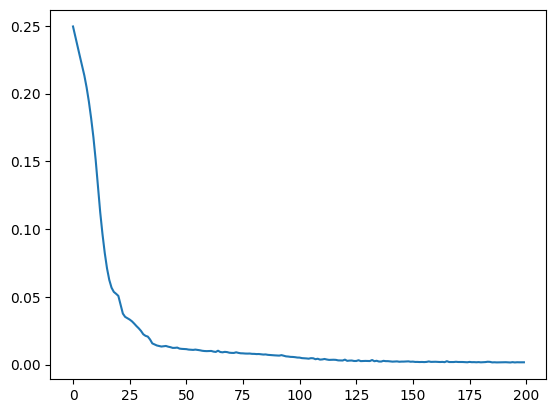

In [8]:
n_epochs = 200  # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf  # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train_std[start : start + batch_size]
            y_batch = Y_train_std[start : start + batch_size]
            # forward pass
            y_pred, _ = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred, _ = model(X_test_std)
    mse = loss_fn(y_pred, Y_test_std)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [9]:
Y_train_pred, weights_train  = model(X_train_std)
Y_test_pred, weights_test = model(X_test_std)

In [10]:
Y_train_std = Y_train_std.detach().numpy()
Y_test_std = Y_test_std.detach().numpy()
Y_train_pred = Y_train_pred.detach().numpy()
Y_test_pred = Y_test_pred.detach().numpy()

,MSE Train,MSE Test,R2 Train,R2 Test
0,0.000619,0.001622,0.986186,0.969744
1,0.000307,0.001108,0.991999,0.964169
2,0.000460,0.002007,0.992176,0.961707


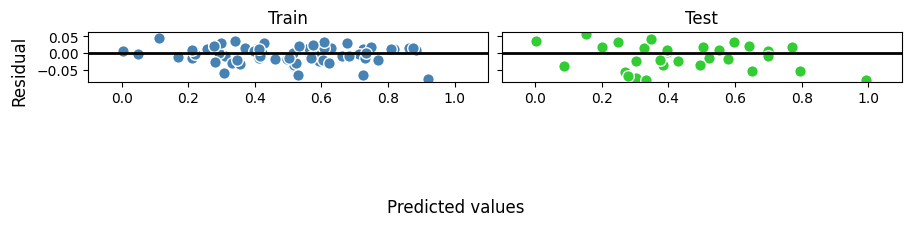

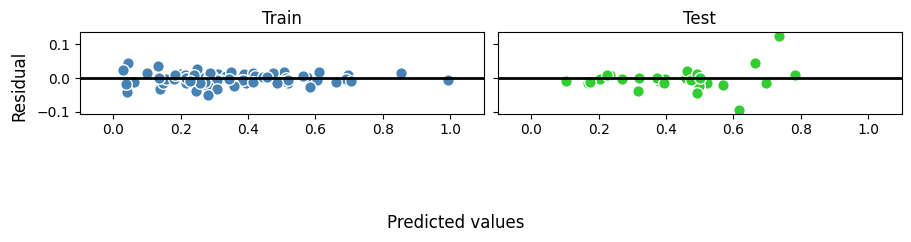

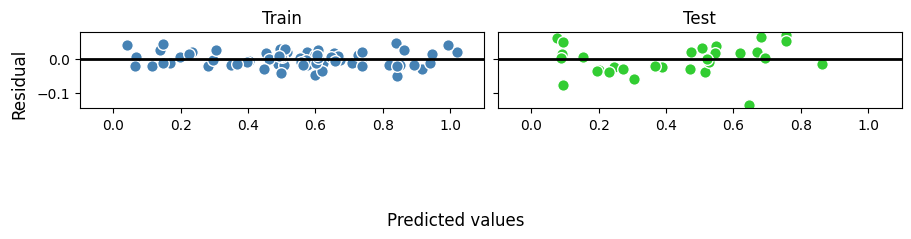

In [11]:
resArr = []
for i in range(Y.shape[1]):
    y_train = Y_train_std[:, i]
    y_test = Y_test_std[:, i]
    y_train_pred = Y_train_pred[:, i]
    y_test_pred = Y_test_pred[:, i]
    plot_res(y_train, y_test, y_train_pred, y_test_pred, xlim=[-0.1, 1.1])
    res = store_results(y_train, y_test, y_train_pred, y_test_pred)
    resArr.append(res)

dfRes = pd.DataFrame.from_dict(resArr)
dfRes

In [12]:
weights_train_mean = weights_train.detach().numpy().mean(axis=0)
weights_test_mean = weights_test.detach().numpy().mean(axis=0)
weights = np.stack([weights_train_mean, weights_test_mean], axis=0)
weights.shape

(2, 47)

In [13]:
dfW = pd.DataFrame(data=weights, columns=X.columns)
dfW

,m1,m2,m3,s1__autocorrelation__lag_8,s1__autocorrelation__lag_9,s1__autocorrelation__lag_7,s1__autocorrelation__lag_6,s1__autocorrelation__lag_5,s1__autocorrelation__lag_4,s1__longest_strike_above_mean,...,"s1__agg_autocorrelation__f_agg_""median""__maxlag_40",s1__approximate_entropy__m_2__r_0.5,"s1__agg_autocorrelation__f_agg_""mean""__maxlag_40",s1__ar_coefficient__coeff_3__k_10,s1__approximate_entropy__m_2__r_0.1,s1__lempel_ziv_complexity__bins_3,s1__partial_autocorrelation__lag_4,"s1__fft_coefficient__attr_""abs""__coeff_7","s1__agg_autocorrelation__f_agg_""var""__maxlag_40",s1__spkt_welch_density__coeff_2
0,0.359262,0.010140,0.004319,0.004934,0.060159,0.003921,0.152361,0.007946,0.003649,0.010099,...,0.005303,0.004545,0.003429,0.011731,0.004790,0.003057,0.005358,0.011777,0.004351,0.005949
1,0.291383,0.011848,0.004499,0.005411,0.054086,0.004057,0.185957,0.009612,0.003632,0.012534,...,0.005849,0.004725,0.003441,0.013245,0.005017,0.003152,0.005877,0.014435,0.004595,0.006355


In [14]:
dfW.loc[0, :].sort_values(ascending=False)

m1                                                    0.359262
s1__autocorrelation__lag_6                            0.152361
s1__autocorrelation__lag_2                            0.084904
s1__partial_autocorrelation__lag_8                    0.066561
s1__autocorrelation__lag_9                            0.060159
s1__partial_autocorrelation__lag_7                    0.033818
s1__number_cwt_peaks__n_5                             0.012751
s1__fft_coefficient__attr_"abs"__coeff_7              0.011777
s1__ar_coefficient__coeff_3__k_10                     0.011731
s1__partial_autocorrelation__lag_6                    0.011544
m2                                                    0.010140
s1__longest_strike_above_mean                         0.010099
s1__permutation_entropy__dimension_3__tau_1           0.008940
s1__cid_ce__normalize_True                            0.008363
s1__autocorrelation__lag_5                            0.007946
s1__autocorrelation__lag_1                            0

In [15]:
dfW.loc[1, :].sort_values(ascending=False)


m1                                                    0.291383
s1__autocorrelation__lag_6                            0.185957
s1__autocorrelation__lag_2                            0.104009
s1__autocorrelation__lag_9                            0.054086
s1__partial_autocorrelation__lag_8                    0.052534
s1__partial_autocorrelation__lag_7                    0.040733
s1__number_cwt_peaks__n_5                             0.015312
s1__partial_autocorrelation__lag_6                    0.014921
s1__fft_coefficient__attr_"abs"__coeff_7              0.014435
s1__ar_coefficient__coeff_3__k_10                     0.013245
s1__longest_strike_above_mean                         0.012534
m2                                                    0.011848
s1__permutation_entropy__dimension_3__tau_1           0.010437
s1__cid_ce__normalize_True                            0.009653
s1__autocorrelation__lag_5                            0.009612
s1__autocorrelation__lag_1                            0